In [1]:
from __future__ import print_function, division
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
from pathlib import Path
import nibabel as nib
from torch.optim import lr_scheduler
import math
from skimage import measure

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

Create utilities for reading from the nib files. Use the nib utils to read a single instance for a given ID from the SISS Dataset. The Dataset object hails from the Torch's Dataset API and is used for creating an iterator tape to read from. Just pass the index over the tape to extract that sample instance.

In [2]:
ROOT_DIR = Path.cwd().parents[0]

In [3]:
def read_nib(path):
    'read from the path'
    img = nib.load(str(path))
    data = img.get_fdata()
    return np.array(data)


def read_single_scan(scan_slice):
    'read the first 4 CT scan slices and 1 mask'
    scan_idx, slice_idx = scan_slice
    scan_dir = ROOT_DIR / 'data' / str(scan_idx)
    scan_data = []
    paths = sorted([x for x in scan_dir.iterdir()])
    for path in paths:
        if path.is_dir():
            scan_type = path / (path.name + '.nii')
            scan_data.append(read_nib(scan_type)[:, :, slice_idx])

    return np.stack(scan_data, axis=-1)

class SISSDataset(Dataset):
    """SISS dataset."""

    def __init__(self, num_slices, num_scans, root_dir, transform=None):
        """
        Args:
            num_slices (int): 154 for number of slices
            num_scans (int): 3 scans available
            root_dir (string): Directory with all the NIB scan blobs.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.num_slices = 15
        self.num_scans = 3
        self.total_samples = num_slices * num_scans
        self.sample_to_path = lambda x: (math.floor(x / num_slices)+1, x % num_slices)
        self.root_dir = root_dir
        self.transform = transform


    def __len__(self):
        return self.total_samples
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = read_single_scan(self.sample_to_path(idx))
        
        if self.transform:
            sample = self.transform((idx,sample))

        return sample

Create the dataset object

In [4]:
siss_dataset = SISSDataset(num_slices=154,
                          num_scans=3,
                          root_dir = Path.cwd().parents[0])

Visualize random samples

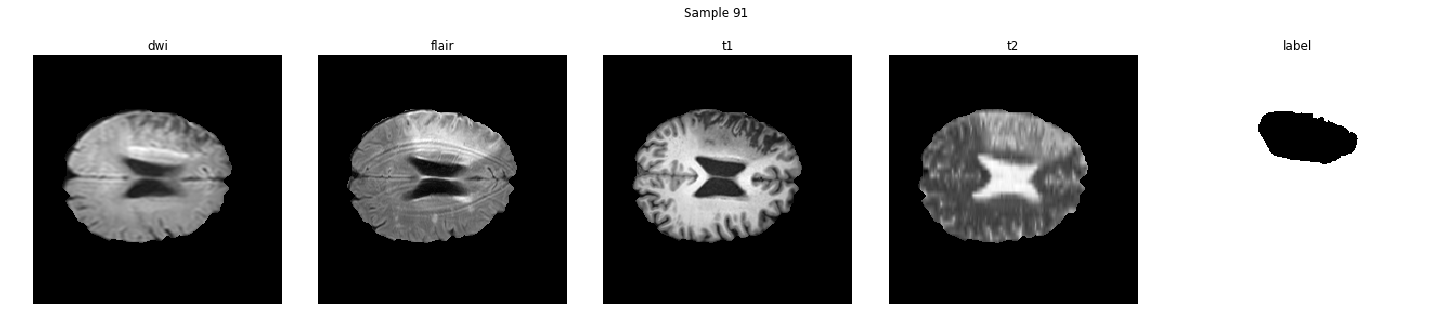

In [5]:
def show_single_img(image, label):
    """Show image"""
    cmap = 'gray'
    if label:
        cmap = 'binary'
    plt.imshow(image, cmap = cmap)

def viz_sample(sample):
    
    fig = plt.figure(figsize= (20,5))
    fig.suptitle('Sample %d' % idx)

    for slice_, scan in enumerate(['dwi', 'flair', 't1', 't2', 'label']):
        ax = plt.subplot(1, 5, slice_ + 1)
        show_single_img(sample[:,:, slice_], scan == 'label')
        plt.tight_layout()
        ax.set_title(scan)
        ax.axis('off')

    plt.show()

idx = 91 # np.random.randint(0, siss_dataset.total_samples)
sample = siss_dataset[idx]
viz_sample(sample)

That random sample

In [6]:
idx

91

RoI Align

In [7]:
import sys

In [8]:
sys.path.append('/Users/hariharan/PycharmProjects/SISS/faster-rcnn.pytorch/lib')

In [9]:
from model.roi_layers import ROIPool

In [10]:
roi_pool = ROIPool((2,2), 1)

In [11]:
roi_pool

ROIPool(output_size=(2, 2), spatial_scale=1)

In [12]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models.vgg import VGG

FCN - 32s

In [13]:
class FCN32s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)

        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)

In [23]:
224/32

7.0

FCN - 16s

In [14]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)

FCN 8s

In [15]:
class FCN8s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
        score = self.bn2(score + x3)                      # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)

FCN

In [16]:
class FCNs(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)
        x2 = output['x2']  # size=(N, 128, x.H/4,  x.W/4)
        x1 = output['x1']  # size=(N, 64, x.H/2,  x.W/2)

        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)


VGG

In [17]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output


ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [18]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [19]:
batch_size, n_class, h, w = 10, 20, 160, 160
# test output size
vgg_model = VGGNet(requires_grad=True)
input = torch.autograd.Variable(torch.randn(batch_size, 3, 224, 224))
output = vgg_model(input)
assert output['x5'].size() == torch.Size([batch_size, 512, 7, 7])


In [20]:
output

{'x1': tensor([[[[1.5707e+00, 0.0000e+00, 1.7488e+00,  ..., 1.0181e+00,
            0.0000e+00, 3.5551e+00],
           [1.1646e+00, 2.9995e+00, 5.0488e+00,  ..., 1.8606e+00,
            1.3307e+00, 2.3082e+00],
           [0.0000e+00, 1.3846e+00, 4.5745e+00,  ..., 1.8077e+00,
            1.1794e+00, 1.1717e+00],
           ...,
           [0.0000e+00, 1.1362e+00, 3.1159e+00,  ..., 1.3401e+00,
            0.0000e+00, 2.0201e+00],
           [0.0000e+00, 3.1216e+00, 4.8380e-01,  ..., 4.5957e+00,
            3.8915e-01, 6.1287e+00],
           [3.8722e-01, 2.0043e+00, 6.4851e-01,  ..., 8.5178e-01,
            3.9759e+00, 4.4757e+00]],
 
          [[2.0203e+00, 2.0215e+00, 2.2452e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [4.1138e-01, 6.9469e+00, 1.7373e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [1.8541e+00, 0.0000e+00, 1.5594e+00,  ..., 2.6880e+00,
            1.4344e+00, 0.0000e+00],
           ...,
           [8.3598e-01, 0.0000e+

In [22]:
for block, block_out in output.items():
    print(block_out.size())

torch.Size([10, 64, 112, 112])
torch.Size([10, 128, 56, 56])
torch.Size([10, 256, 28, 28])
torch.Size([10, 512, 14, 14])
torch.Size([10, 512, 7, 7])


In [ ]:
class FCN

In [ ]:
fcn_model = FCN8s(pretrained_net=vgg_model, n_class=n_class)
input = torch.autograd.Variable(torch.randn(batch_size, 3, h, w))
output = fcn_model(input)
assert output.size() == torch.Size([batch_size, n_class, h, w])